# 카메라 스티커

## 1. 이미지 준비하기

### 디렉토리 만들기

 - $ mkdir -p ~/aiffel/camera_sticker/models 
 
 - $ mkdir -p ~/aiffel/camera_sticker/images

 
 


### 데이터 파일 준비하기
- ln -s ~/data/* ~/aiffel/camera_sticker/images

### 이미지 파일 경로
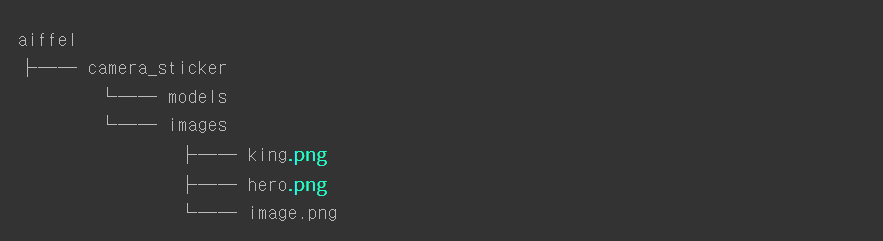

## 2. 이미지 확인하기
### 2-1 필요한 라이브러리 불러오기

### 이미지 읽어올 때 주의할 점
- opencv는 이미지 파일을 읽을 때, BGR순서로 읽기 때문에 matplotlib를 이용하려면 RGB로 바꾸어 줘서 출력해줘야 한다.

In [2]:
# 필요한 라이브러리 불러오기

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

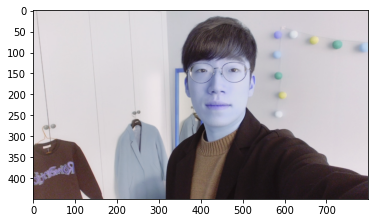

In [119]:
# 이미지 읽어오기
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/image.png'
# OpenCV로 이미지를 불러오기
img_bgr = cv2.imread(my_image_path)    
# 원본 이미지 따로 복사
img_show = img_bgr.copy() 
# 이미지 출력하기
plt.imshow(img_bgr)
plt.show()

### 색 보정해서 출력하기

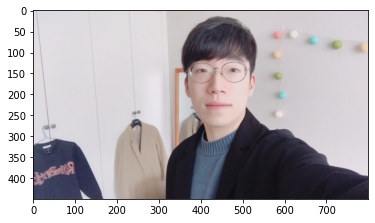

In [120]:
# opencv는 BGR(파랑, 녹색, 빨강)을 사용하기 때문에 컬러를 보정해서 출력해야 함

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

### imread의 flag 설명
---

- 이미지 읽기의 flag는 1, 0, -1의 값을 갖습니다.

- cv2.IMREAD_COLOR (flag=1): 이미지 파일을 Color로 읽어들입니다. 투명한 부분은 무시되며, Default값입니다.

- cv2.IMREAD_GRAYSCALE (flag=0) : 이미지를 Grayscale로 읽어 들입니다. 실제 이미지 처리시 중간단계로 많이 사용합니다.

- cv2.IMREAD_UNCHANGED (flag=-1): 이미지파일을 alpha channel까지 포함하여 읽어 들입니다.


## 3. 얼굴 검출 face detection
- dlib의 face detector는 HOG(Histogram of Oriented Gradients)와 SVM(Support Vector Machine)을 사용해서 얼굴을 찾습니다.
### 1.HOG는 이미지에서 색상의 변화량을 나타낸 것

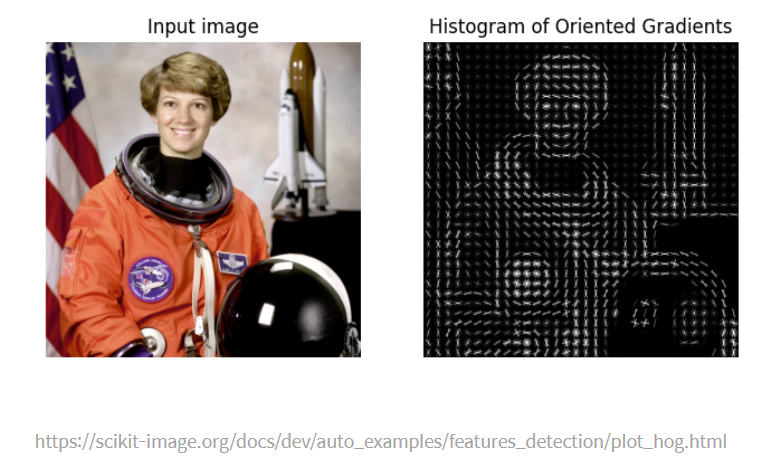
https://scikit-image.org/docs/dev/auto_examples/features_detection/plot_hog.html
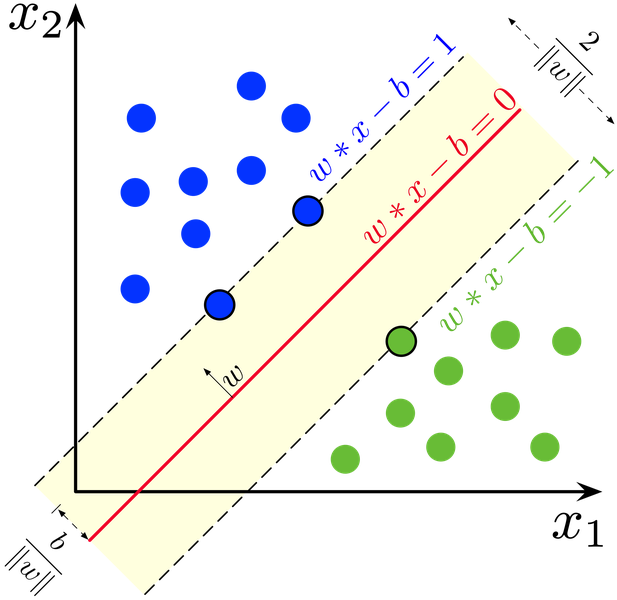
- 이미지의 색상만 가지고는 SVM이 큰 힘을 발휘하지 못합니다. 하지만 이미지가 HOG를 통해 벡터로 만들어진다면 SVM이 잘 작동

### 2. 얼굴의 위치 찾기
- sliding window
   - 작은 영역(window)을 이동해가며 확인하는 방법
   - 큰 이미지의 작은 영역을 잘라 얼굴이 있는지 확인하고, 다시 작은 영역을 옆으로 옮겨 얼굴이 있는지 확인하는 방식   
   

### 3.1 detector_hog를 이용해서 사각형 정의하기


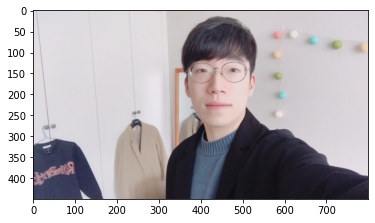

In [121]:
# dlib을 활용해 hog detector를 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해서 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

plt.imshow(img_rgb)
plt.show()

> detector_hog의 두 번째 파라미터는 이미지 피라미드의 수입니다. <br>
이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드라고 합니다. <br>
이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능


> ➰ upsampling이란,
간단하게 데이터의 크기를 키우는 것입니다. <br>
일반적으로 CNN의 레이어를 통과하면서 이미지의 크기를 줄이는 것을 down sampling이라고 하는데,<br>
down sampling의 반대 개념이 upsampling인 셈이죠.

 #### https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html

### 3.2 찾은 얼굴을 화면에 출력

rectangles[[(345, 98) (531, 284)]]


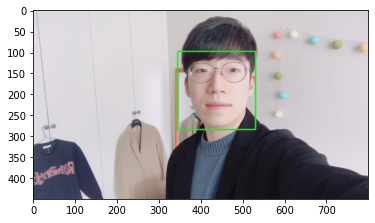

In [122]:
# 사각형 영역 설정해서 출력하기 
for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
print(dlib_rects)   

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 4. 얼굴 랜드마크 face landmark
- 스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요
- **이목구비의 위치를 추론**하는 것을 **face landmark localization** 기술
- face landmark는 detection 의 결과물인 **bounding box** 로 잘라낸(crop) 얼굴 이미지를 이용

### Object keypoint estimation 알고리즘

**Face landmark와 같이 객체 내부의 점을 찾는 기술**을 object keypoint estimation이라고 합니다. keypoint를 찾는 알고리즘은 크게 2가지로 나누어 집니다.

1) top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2) bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

이번 예제에서는 1번 방식으로 진행
<br><br>

### Dlib landmark localization
---
잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾습니다.
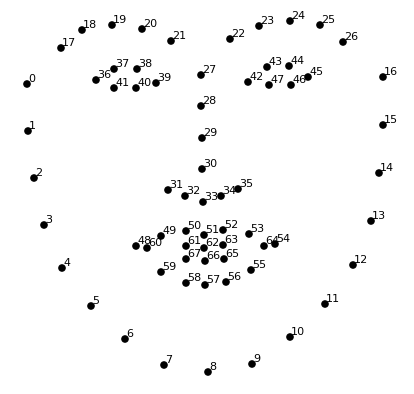

이 때 점의 개수는 데이터셋과 논문마다 다릅니다. 예를 들면, AFLW 데이터셋은 21개를 사용하고 ibug 300w 데이터셋은 68개를 사용
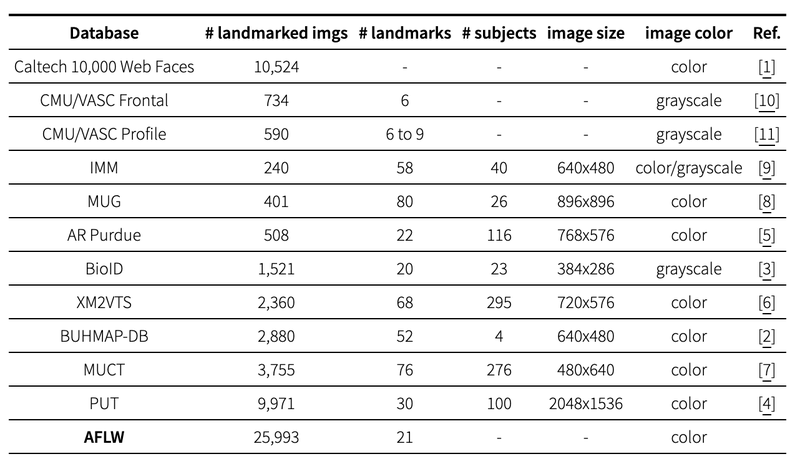


### Dlib의 제공되는 모델을 사용
- 먼저 공개되어 있는 weight file을 다운로드
- 해당 모델파일은 bz2 압축파일 형태로 제공되어 압축을 풀어준 후 사용
- $ wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2<br>

- $ mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models<br>
  
- $ cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

<br><br>
### points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근
points 는 dlib.full_object_detection 의 객체이기 때문에 parts() 함수로 개별 위치에 접근할 수 있습니다. <br>
조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환해 주었습니다.<br>
따라서 list_points 는 tuple (x, y) 68개로 이루어진 리스트가 됩니다. <br>
이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장<br>

### 4-1 shape_predictor를 이용해 랜드마크 찾기

In [123]:
# 저장한 landmark 모델을 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor 는 RGB 이미지와 dlib.rectangle을 입력 받아 dlib.full_object_detection 를 반환
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


### 4.2 랜드마크를 영상에 출력


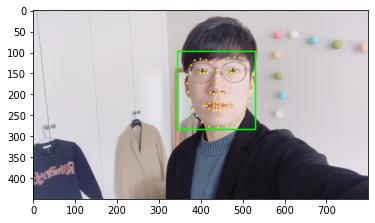

In [124]:
# 랜드마크 보기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 5. 스티커 적용하기

In [125]:
# 좌표확인
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index는 30 입니다
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.height()//2
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(437, 182)
(x,y) : (437,89)
(w,h) : (187,187)


In [126]:
# 준비해 둔 왕관 이미지를 읽고 dlib_rect로 resize 
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker, (w, h))

print (img_sticker.shape)

(187, 187, 3)


In [127]:
# 원본 이미지에 스티커 이미지를 추가하기 위해서 x, y 좌표를 조정, 이미지 시작점은 top-left 좌표이기 때문
refined_x = x - w // 2
refined_y = y - h
print ('(x, y) : (%d, %d)'%(refined_x, refined_y))

(x, y) : (344, -98)


스티커의 시작점이 얼굴 사진의 영역을 벗어나면 음수로 표현됩니다.<br> 
그런데 opencv 데이터는 numpy ndarray 형태의 데이터를 사용합니다.<br> 
ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리를 해줘야 합니다.<br>
따라서 그림에서 보시는 것처럼 원본 이미지의 범위를 벗어난 스티커 부분을 제거해 주어야 합니다.
<br><br><br>
스티커가 원본 이미지의 범위를 넘어가는 경우는 하나 더 있습니다.<br>
바로 스티커의 시작점 + 스티커 사진의 크기가 원본 이미지의 크기보다 큰 경우입니다. <br>
스티커 사진의 오른쪽이나 아래쪽으로 넘어가는 경우죠. 이 경우는 어떻게 처리해야 하는지 생각해보세요.

In [128]:
# -y 크기만큼 스티커를 crop 하고, top 의 x좌표와 y 좌표를 각각의 경우에 맞춰 원본 이미지의 경계 값으로 수정하면 아래와 같은 형식
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (344,0)


sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다. <br>
예제에서는 (344,0) 부터 (344+187, 0+89) 범위의 이미지를 의미합니다.

스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용합니다. <br>
따라서 np.where를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용하시면 됩니다.<br>
img_show 에 다시 적용

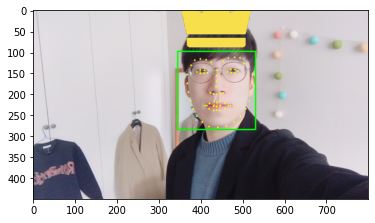

In [129]:
# 원본 이미지에 스티커를 적용
# 길어서 복잡해 보이지만 img_show[from:to] 형식입니다

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

# 결과 이미지 출력
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

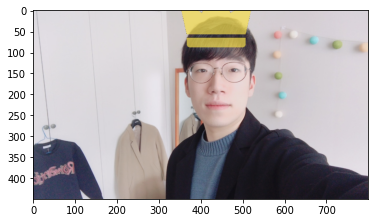

In [131]:
# bounding box와 landmark를 제거하고 최종 결과만 출력
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.3, np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8), 0.7, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 고양이 스티커 붙이기

## Step 1. 라이브러리 설치

In [ ]:
# 필요한 라이브러리 가져오기

import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib

## Step 2. 이미지 불러오기

### 이미지 읽어올 때 주의할 점
- opencv는 이미지 파일을 읽을 때, BGR순서로 읽기 때문에 matplotlib를 이용하려면 RGB로 바꾸어 줘서 출력해줘야 한다.

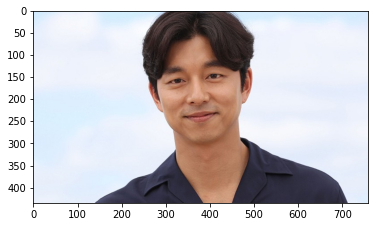

In [174]:
# 이미지 가져오기

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/kongyoo.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()      # 출력용 이미지를 복사

# plt.imshow 이전에 RGB 이미지로 바꾸기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## Step 3. 얼굴 검출 face detection


rectangles[[(283, 98) (469, 284)]]


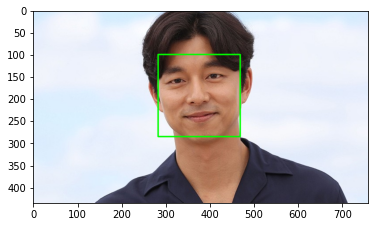

In [175]:
# detector를 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해서 얼굴의 bounding box를 추출

dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 4. 얼굴랜드마크
### 4-1 shape_predictor를 이용해 랜드마크 찾기

In [176]:
# 저장한 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor를 이용해 랜드마크 포인트 찾기
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


### 4.2 랜드마크를 영상에 출력

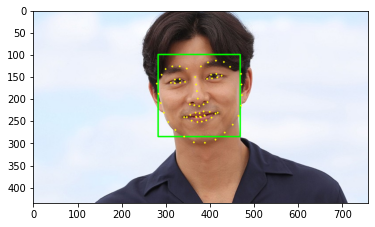

In [177]:
# 랜드마크 보기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## Step 5. 스티커 적용하기

In [178]:
# 좌표확인 
plt.show()
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index를 이용해 코의 좌료 출력
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(373, 198)
(x,y) : (373,198)
(w,h) : (187,187)


In [179]:
# 준비해 둔 스티커 이미지를 읽어서 사이즈 변형
# 고양이 수염 스티커
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker, (w, h))


# 왕관 스티커 
sticker_path2 = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png'
img_sticker2 = cv2.imread(sticker_path2) 
img_sticker2 = cv2.resize(img_sticker2, (w, h)) 
print ("고양이 수염 스티커 :", img_sticker.shape)
print ("왕관 스티커 :", img_sticker2.shape)

고양이 수염 스티커 : (187, 187, 3)
왕관 스티커 : (187, 187, 3)


In [180]:
# 고양이 스티커 추가하기 위해 스티커 좌표 조정
refined_x = x - w // 2
refined_y = y - (h//2) + 10

# 왕관 스티커 좌표 조정
refined_x2 = x - w // 2
refined_y2 = y - (h + 100)


print ('고양이 수염 (x, y) : (%d, %d)'%(refined_x, refined_y))
print ('왕관 (x, y) : (%d, %d)'%(refined_x2, refined_y2))


고양이 수염 (x, y) : (280, 115)
왕관 (x, y) : (280, -89)


In [181]:
# 음수를 양수 만들기 위해 조정
if refined_x2 < 0: 
    img_sticker2 = img_sticker2[:, -refined_x2:]
    refined_x2 = 0
if refined_y2 < 0:
    img_sticker2 = img_sticker2[-refined_y2:, :]
    refined_y2 = 0

print ('고양이 수염 (x,y) : (%d,%d)'%(refined_x, refined_y))
print ('왕관 (x,y) : (%d,%d)'%(refined_x2, refined_y2))



고양이 수염 (x,y) : (280,115)
왕관 (x,y) : (280,0)


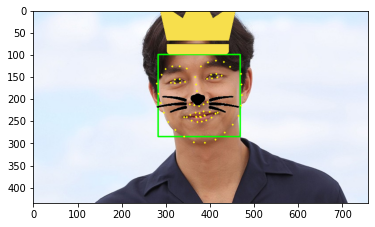

In [182]:
# 원본에 스티커 적용
# 고양이 수염
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 왕관
sticker_area2 = img_show[refined_y2:refined_y2 + img_sticker2.shape[0], refined_x2:refined_x2+img_sticker2.shape[1]]
img_show[refined_y2:refined_y2+img_sticker2.shape[0], refined_x2:refined_x2+img_sticker2.shape[1]] = \
    np.where(img_sticker2==0,sticker_area2,img_sticker2).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

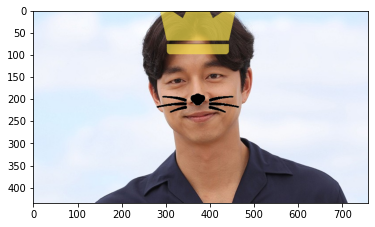

In [183]:
#  최종 결과만 출력
# 고양이 수염
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

# 왕관
sticker_area2 = img_bgr[refined_y2:refined_y2 + img_sticker2.shape[0], refined_x2:refined_x2 + img_sticker2.shape[1]]
img_bgr[refined_y2:refined_y2 + img_sticker2.shape[0], refined_x2:refined_x + img_sticker2.shape[1]] = \
    cv2.addWeighted(sticker_area2, 0.3, np.where(img_sticker2==0,sticker_area2,img_sticker2).astype(np.uint8), 0.7, 0)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## Step 6. 문제점 찾아보기
- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
- 실행 속도가 중요할까요?
- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

### 6-1 얼굴의 각도에 따라 스티커가 어떻게 변해야 할까요??

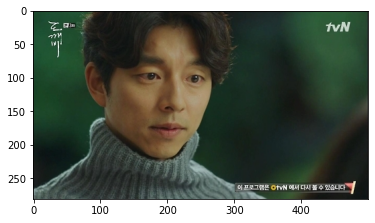

rectangles[[(132, 47) (287, 202)]]


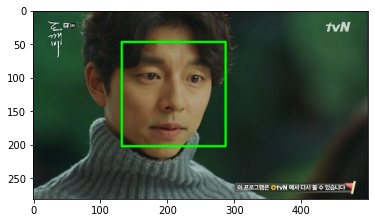

68


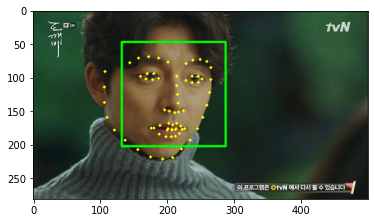

(216, 138)
(x,y) : (216,138)
(w,h) : (156,156)
고양이 수염 스티커 : (156, 156, 3)


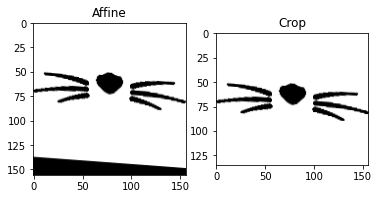

(x,y) : (138,70)


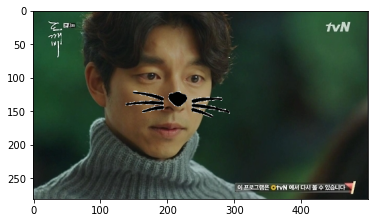

In [3]:
# 이미지 가져오기

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/kong.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()      # 출력용 이미지를 복사

# plt.imshow 이전에 RGB 이미지로 바꾸기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


# detector를 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해서 얼굴의 bounding box를 추출
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
    
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 저장한 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor를 이용해 랜드마크 포인트 찾기
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))
# 랜드마크 보기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 좌표확인 
plt.show()
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # 코의 index를 이용해 코의 좌료 출력
    x = landmark[30][0]
    y = landmark[30][1]
    w = h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))
    

# 고양이 수염 스티커
sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
img_sticker = cv2.imread(sticker_path) 
img_sticker = cv2.resize(img_sticker, (w, h))

print ("고양이 수염 스티커 :", img_sticker.shape)

# 고양이 스티커 추가하기 위해 스티커 좌표 조정
refined_x = x - w // 2
refined_y = y - (h//2) + 10



# 회전할 좌표 매트릭스
pst1 = np.float32([[landmark[21][0], landmark[21][1]], [landmark[22][0], landmark[21][1]], [landmark[27][0], landmark[27][1]]])
pst2 = np.float32([[landmark[21][0], landmark[21][1]], [landmark[22][0], landmark[22][1]], [landmark[27][0], landmark[27][1]]])

M = cv2.getAffineTransform(pst1, pst2)
dst_1 = cv2.warpAffine(img_sticker, M, (w, h))
dst = dst_1[:135, :165]
plt.subplot(121), plt.imshow(dst_1[:, :, ::-1]), plt.title('Affine')
plt.subplot(122), plt.imshow(dst[:, :, ::-1]), plt.title('Crop')

plt.show()


# 음수를 양수 만들기 위해 조정
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# 원본에 스티커 적용
# 고양이 수염
sticker_area = img_show[refined_y:refined_y+dst.shape[0], refined_x:refined_x+dst.shape[1]]
img_show[refined_y:refined_y+dst.shape[0], refined_x:refined_x+dst.shape[1]] = \
    np.where(dst==255,sticker_area,dst).astype(np.uint8)

#  최종 결과만 출력
# 고양이 수염
sticker_area = img_bgr[refined_y:refined_y +dst.shape[0], refined_x:refined_x+dst.shape[1]]
img_bgr[refined_y:refined_y +dst.shape[0], refined_x:refined_x+dst.shape[1]] = \
    np.where(dst==255,sticker_area,dst).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

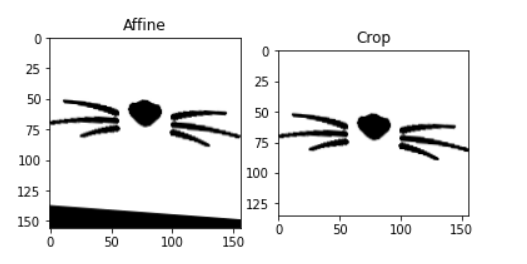
- 얼굴 회전에 맞게 AffineTransform()을 했는 데, 이미지가 회전하면서, 검은 부분이 생겼다..<br>
  그래서 스티커를 잘라서 넣었다. 
- 또 다른 문제점은 회전시켜서 붙였더니 선처리가 매끄럽지 못해서 햐얀 부분이 조금씩 보인다.
  이건 내가 해결할 수 있는 문제를 뛰어넘어서.. 그만..
  

### 6-2 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?

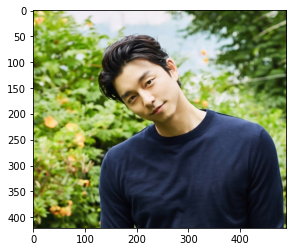

rectangles[[(163, 116) (270, 223)]]


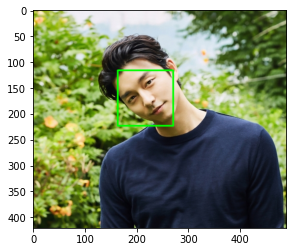

68


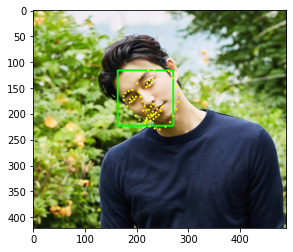

In [9]:

my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/kong1.png'
img_bgr = cv2.imread(my_image_path)   
img_show = img_bgr.copy()      # 출력용 이미지를 복사

# plt.imshow 이전에 RGB 이미지로 바꾸기
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()


# detector를 선언
detector_hog = dlib.get_frontal_face_detector()

# detector_hog를 이용해서 얼굴의 bounding box를 추출
# opencv 의 bgr 이미지를 rgb로 변환
# img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

print(dlib_rects)

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 저장한 랜드마크 모델 불러오기
model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

# landmark_predictor를 이용해 랜드마크 포인트 찾기
list_landmarks = []

# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    # face landmark 좌표를 저장해둡니다
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

# 랜드마크 보기
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()


#### 너무 심하게 기울어지니 얼굴을 잘 찾지만.. 랜드마크의 위치가 잡히지 않는다.
- 심하게 기울어진 사진은 랜드마크를 잡기 힘든 것 같다..
- 회전하기 위해서 스티커를 AffineTransform()을 하니 스티커가 제대로 출력되지 않는다.
  시간 부족으로 패스~~
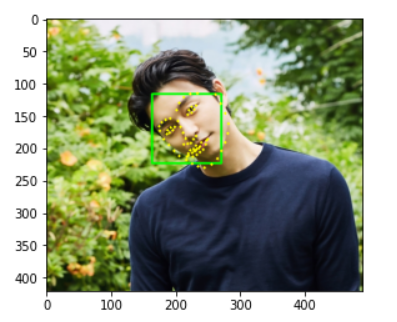

### 함수정의하기

In [21]:

def get_sticker(my_image_path):
    img_bgr = cv2.imread(my_image_path)   
    img_show = img_bgr.copy()      # 출력용 이미지를 복사

    # plt.imshow 이전에 RGB 이미지로 바꾸기
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.show()


    # detector를 선언
    detector_hog = dlib.get_frontal_face_detector()

    # detector_hog를 이용해서 얼굴의 bounding box를 추출
    # opencv 의 bgr 이미지를 rgb로 변환
    # img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

    print(dlib_rects)

    for dlib_rect in dlib_rects:
        l = dlib_rect.left()
        t = dlib_rect.top()
        r = dlib_rect.right()
        b = dlib_rect.bottom()

        cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

    img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()

    # 저장한 랜드마크 모델 불러오기
    model_path = os.getenv('HOME')+'/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    landmark_predictor = dlib.shape_predictor(model_path)

    # landmark_predictor를 이용해 랜드마크 포인트 찾기
    list_landmarks = []

    # 얼굴 영역 박스 마다 face landmark를 찾아냅니다
    for dlib_rect in dlib_rects:
        points = landmark_predictor(img_rgb, dlib_rect)
        # face landmark 좌표를 저장해둡니다
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)

    print(len(list_landmarks[0]))
    # 랜드마크 보기
    for landmark in list_landmarks:
        for point in landmark:
            cv2.circle(img_show, point, 2, (0, 255, 255), -1)

    img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    plt.imshow(img_show_rgb)
    plt.show()

    # 좌표확인 
    plt.show()
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        print (landmark[30]) # 코의 index를 이용해 코의 좌료 출력
        x = landmark[30][0]
        y = landmark[30][1]
        w = h = dlib_rect.width()
        print ('(x,y) : (%d,%d)'%(x,y))
        print ('(w,h) : (%d,%d)'%(w,h))


    # 고양이 수염 스티커
    sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/cat-whiskers.png'
    img_sticker = cv2.imread(sticker_path) 
    img_sticker = cv2.resize(img_sticker, (w, h))

    print ("고양이 수염 스티커 :", img_sticker.shape)

    # 고양이 스티커 추가하기 위해 스티커 좌표 조정
    refined_x = x - w // 2
    refined_y = y - (h//2) + 10

    # 음수를 양수 만들기 위해 조정
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0

    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

    # 원본에 스티커 적용
    # 고양이 수염
    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

    #  최종 결과만 출력
    # 고양이 수염
    sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255,sticker_area,img_sticker).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
    plt.show()


### 조금 어두운 이미지는 어떻게 될까요?

#### 1. 어두워도 얼굴의 윤곽이 뚜렷하면 수염이 그려진다..


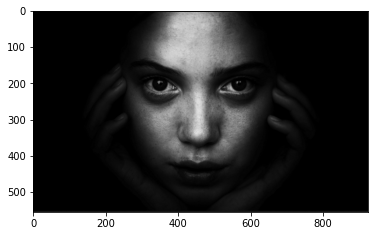

rectangles[[(247, 119) (632, 504)]]


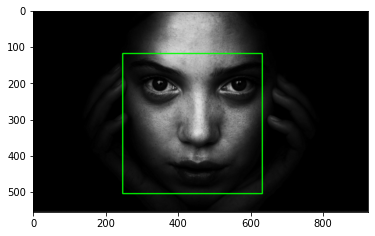

68


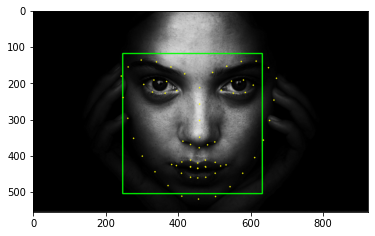

(459, 349)
(x,y) : (459,349)
(w,h) : (386,386)
고양이 수염 스티커 : (386, 386, 3)
(x,y) : (266,166)


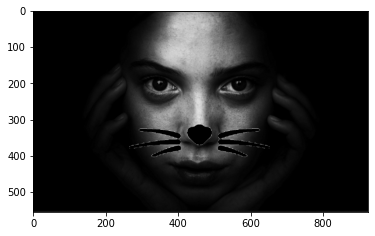

In [22]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/dark.png'
get_sticker(my_image_path)

#### 2. 어두운데 얼굴의 윤곽이 뚜렷하지 않으면 얼굴을 찾지 못한다.

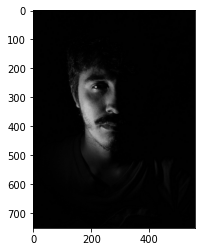

rectangles[]


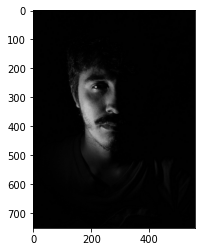

IndexError: list index out of range

In [23]:
my_image_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/darkman.png'
get_sticker(my_image_path)

## 회고

### 1. 이번 프러젝트에서 어려웠던 점

- 고양이 수염을 붙일 때, 왕관을 붙이던 y좌표를 그대로 써서 헤메었다.
  좌표를 이해했다기 보다는 계속 좌표를 수정하면서 조정을 했다.
  나중에 은실 퍼실님이 알려 주셔서 대강 이해하고 하다보니 원래 y좌표의 시작을 바꾸고 조정해서 쉽게 수염을 완성했다.
  
- 프로젝트 끝에 왕관을 블랜딩한 것이 나왔다..
  이것부터가 완전한 고난의 시작이다.<br>
  addWeight()함수를 이용한다면 된다고 해서 찾아봤더니, 이미지 사이즈가 같아야 한다고.. 구글신들이 그랬다.
  그래서 비트맵을 찾았다.<br>
  헐 비트맵 연산도 장난이 아니다..<br>
  그래서 주말에 도서관에 갔다. openCV에 대한 책을 찾아서 읽기도 하고, 유튜브 강의도 찾아보았다.
  첫번째 나의 오류는 이미지 합성인데, 다른 곳에서 찾았고,
  우여곡절 끝에 addWeight를 찾았더니, 사이즈가 다를 때는 데이터 타입을 명시해 주면 가능하다고 나왔다.
  데이터 타입을 명시하면 되는 데.. 어디에 어떻게 해야 하나... 고민을..
  우리 조원 **박성돈**님이 명예의 전당에서 찾으신 방법으로 바꿨다...
  그 분의 이름은 바로~~~ **유현지**님이다.
  좌절감이 들지만.. 알고는 싶었고, 어디에 어떻게 적용하는 지 알고 싶어서.. 배웠다.
  후회하지는 않는다.. ㅎㅎ
  
### 2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

#### 2.1 알아낸 점
- addWeight를 찾다보니 여러 가지 연산이 가능하다는 것을 알게 되었다.
- 성돈님의 도움을 받아서 해보니 원본 출력할 때, 데이터 타입이 명시가 되어 있었다.. ㅎㅎ
- 기울어진 얼굴을 할 때는 getAffineTransform()을 썼는 데, 깨끗하지 않게 되었다.
   - 그래도 내가 알아내서 하니 기분은 좋다~!!^^


#### 2.2 아직 모호한 점
- AffineTransform()을 적용하니 절대좌표가 되서 안정적이지 않다.<br>
  상대좌표를 구하는 방법에 대해 연구를 해야할 것 같다.


### 3. 루브릭 평가 지표를 맞추기 위해 시도한 것들
- 왕관 이미지를 연하게 하기 위해 addWeight()를 쓰는 것 배우기
- 스티커 회전을 위해 AffineTransform()을 이용(), 기울어진 사진을 찾아서 적용하기
- 어두운 이미지를 찾기


### 4. 만약에 루브릭 평가 관련 지표를 달성하지 못했을 때, 이유에 관한 추정
- 회전이 하나의 사진에는 잘 되지만 모든 사진에는 적용하지 못하는 것 같다.
  절대좌표를 상대좌표로 바꾸어야 하는 데, 그것을 계산할 시간이 부족하다..<br>
- 회전을 하고 나니 회전하고 남은 부분이 생겨서 Crop를 했는 데, 크롭도 비율로 할 수 있는 방법이 있을까??

### 5. 자기다짐

- 이미지 블랜딩.. 알파값을 찾는 데 시간을 너무 많이 낭비했는 데, python의 코드가 길어지면 일단 지나치려고 한다.<br>
  긴 코드구문을 보면 일단 회피하는 습성을 버리고...<br>
  하루에 하나씩이라도 파이썬 공부를 해야할 것 같다..
